# Data Preparation

## Accessing Data in Google Collab

In [1]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Move to where Data is located
%cd 'drive/My Drive/ChBE 6745 Project/Data'

/content/drive/My Drive/ChBE 6745 Project/Data


## Data Treatment

### Original Data

In [17]:
# Read in the data
import numpy as np
import pandas as pd
import pylab as plt
df = pd.read_csv("Data/MCC_raw.csv")
data = df.drop([0]).astype(float)
data = data.iloc[10:,:]
data.head()

,Adhesive-1-1,Unnamed: 1,Unnamed: 2,Adhesive-2-1,Unnamed: 4,Unnamed: 5,Adhesive-3-1,Unnamed: 7,Unnamed: 8,Adhesive-4-1,...,Unnamed: 113,Fiber-17,Unnamed: 115,Unnamed: 116,Fiber-18,Unnamed: 118,Unnamed: 119,Fiber-19,Unnamed: 121,Unnamed: 122
11,74.119,12.059,0.140,75.079,12.488,0.145,75.121,11.624,0.143,74.643,...,0.042,74.266,10.131,0.171,74.968,11.854,0.120,74.118,10.490,0.168
12,74.164,12.250,0.127,75.171,12.435,0.142,75.248,11.685,0.186,74.702,...,0.119,74.347,10.072,0.170,75.106,11.765,0.199,74.190,10.556,0.126
13,74.262,11.895,0.143,75.283,12.660,0.204,75.310,11.725,0.190,74.760,...,0.127,74.444,10.118,0.178,75.182,11.714,0.213,74.325,10.612,0.207
14,74.411,12.093,0.247,75.423,12.547,0.252,75.438,11.437,0.190,74.839,...,0.101,74.506,10.016,0.159,75.290,11.762,0.184,74.417,10.497,0.228
15,74.510,12.000,0.248,75.520,12.741,0.237,75.561,11.358,0.251,74.915,...,0.125,74.617,10.227,0.173,75.402,11.920,0.221,74.536,10.364,0.211


In [18]:
# Read in Flame Retardant Test Results
df = pd.read_csv("Data/FR_results.csv")
FR_labels = df.iloc[:,1]
df.head()

,Material,Result
0,Adhesive-1,2
1,Adhesive-2,2
2,Adhesive-3,1
3,Adhesive-4,0
4,Adhesive-5,0


### Baseline Correction

To calculate most accurate features, the baseline corrected curve should be flat (no slope for the area before and after main peaks) and smooth (with no small peaks before 300C). Therefore, the baseline correction function can be divided into three steps, including (1) curve flattening (2) gradient calculation and filtration (3) noise removal.


(1) curve flattening: 

the original dataset might result in a slope (can be either descending or ascending) before  and after the main peaks. To obtain accurate results, the slope area must be flattened. A library called Rampy, which was developed by Charles, et. al. from the Australian National University, was applied to flatten the tilt area.

(2) gradient calculation and filtration:

After the curve has been flattened, the noisy points (usually demonstrated as small peaks at areas where temperature is less than 300C) have to be removed. One approach is to identify the starting point of the first main peak, and set the y-coordination of all points prior to that point equal to 0. The key is to gather the correct starting point of the first peak. np.gradient() function was first used to calculate the first derivative of each point. A Savitzky-Golay filter was then applied to smooth the gradient curve. After that, the function reads through the filtered gradient curve and records the points that satify: the value of first derivative of 10 consecutive points is larger than 1.0. The recorded points can be considered where the peak is ascending and stored in array ns[].

(3) noise removal:

After identifying the starting point of the peak (ns[0]), one additional step was added. That is, finding the x-intercept of the line crossing first and second point (ns[0] & ns[1]) found in the previous step. This procedure allows us to find a more accurate starting point, considering some of the points identified in step (2) are not even close to x-axis. The newly identified point will also be the split point of noise removal. The y-value of every points ahead of the new starting point will be set to 0. 

In [19]:
# run if rampy is not installed
%pip install rampy

Note: you may need to restart the kernel to use updated packages.


In [20]:
# imports
import rampy as rp
from scipy.signal import savgol_filter

# finds the baseline and subtracts it from the raw data
#
# params: x, array of temperature values; y, array of HRR values
# returns: y_base_corr, baseline corrected arrays; 
#          x_int, initial temperature of the curve (ignition temperature defined internally in 3M)
# https://github.com/charlesll/rampy
# https://github.com/charlesll/rampy/blob/master/examples/baseline_fit.ipynb


# function flattening the curve and record the points where peaks are ascending
# details can be found in the descriptive cell above
def baseflatten(x,y):
    bir = np.array([[0,800]])
    y_corrected, background = rp.baseline(x,y,bir,"arPLS",lam=10**10) #flatten the curve
    y_diff=np.gradient(y_corrected[:,0],x) #calculate gradients of each point
    y_diff_filtered=savgol_filter(y_diff,51,5) #smooth the gradient curve
    ns=[] # array that stores the points where peaks are ascending
    for n in range(y_diff.shape[0]):
        if all(diff>1.0 for diff in y_diff_filtered[n:n+10])==True:
            ns.append(n)
    return ns,y_corrected,y_diff_filtered
   
#Find the x-intercept given two points 
def calc_intercept(x1,y1,x2,y2):
    slope=(y2-y1)/(x2-x1)
    c=y1-slope*x1
    x_int=-c/slope
    return slope,c,x_int

#Find the MCC curve with noise removed 
def noiseremove(x,y_corr,x_int,x1,slope,c):
    for j in range(x.shape[0]):
        if x[j]<=x_int:
            y_corr[j,0]=0
        elif x[j]<=x1:
            y_corr[j,0]=slope*x[j]+c
        else:
            break
    return y_corr

def baseline_correction(x,y):

    #flatten the curve
    ns,y_corrected,y_diff_filtered=baseflatten(x,y)

    #identify the first two points where the peak starts
    [x1,y1]=[x[ns[0]],y_corrected[ns[0],0]]
    [x2,y2]=[x[ns[1]],y_corrected[ns[1],0]]
    slope,c,x_int=calc_intercept(x1,y1,x2,y2) #x_int is the x-intercept, which represents the ignition temperature 
    
    y_base_corr=noiseremove(x,y_corrected,x_int,x1,slope,c)
    return x,y_base_corr,x_int

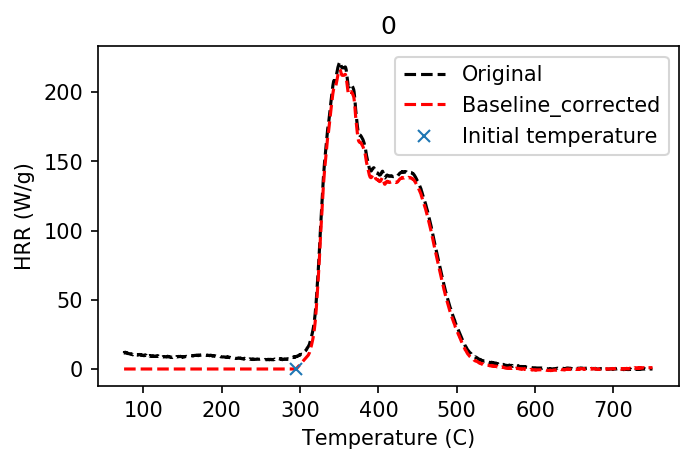

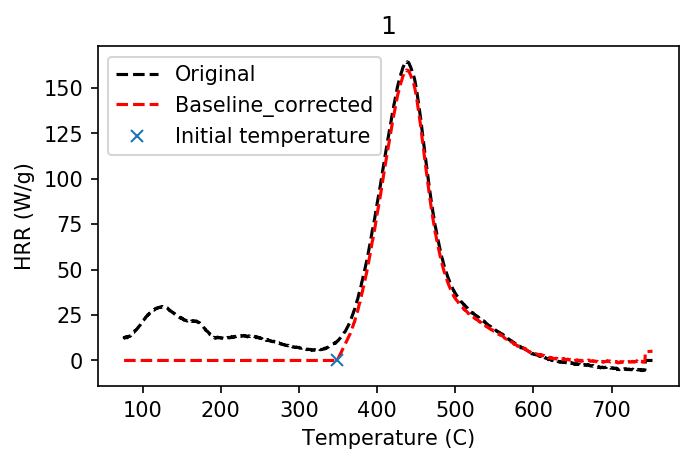

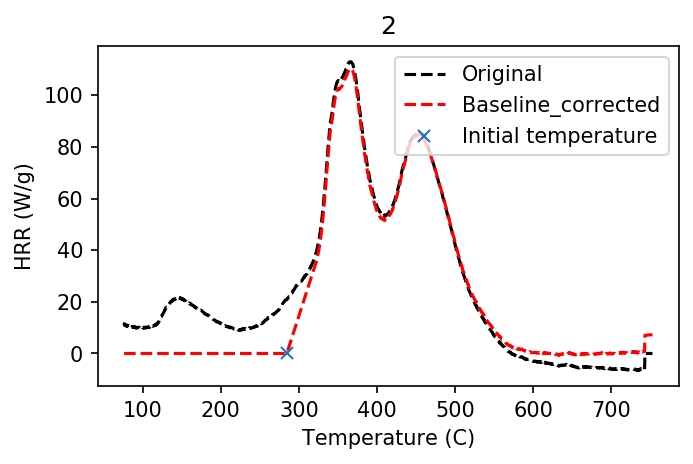

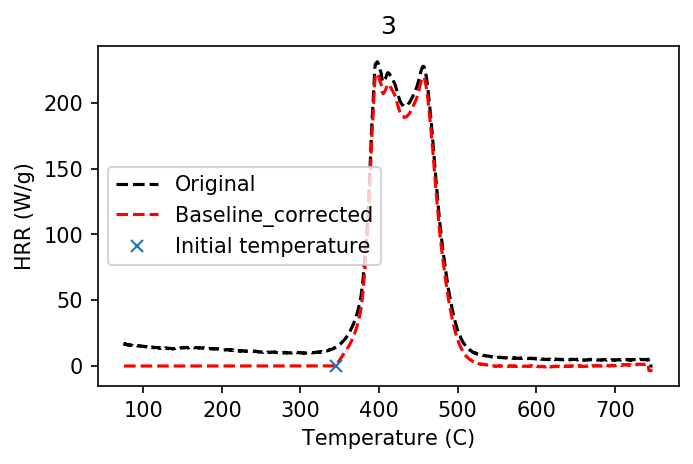

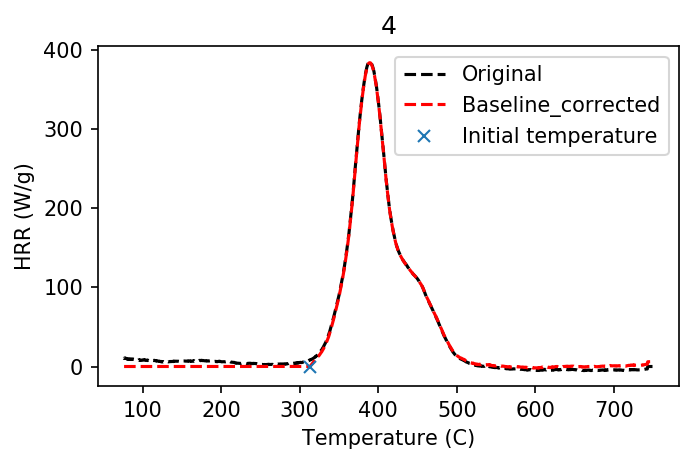

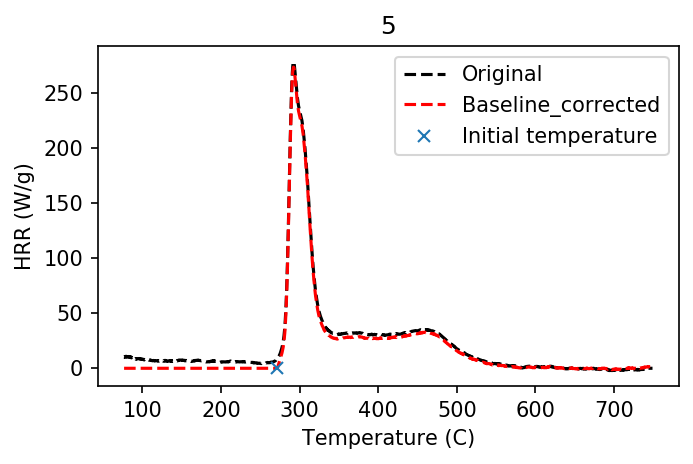

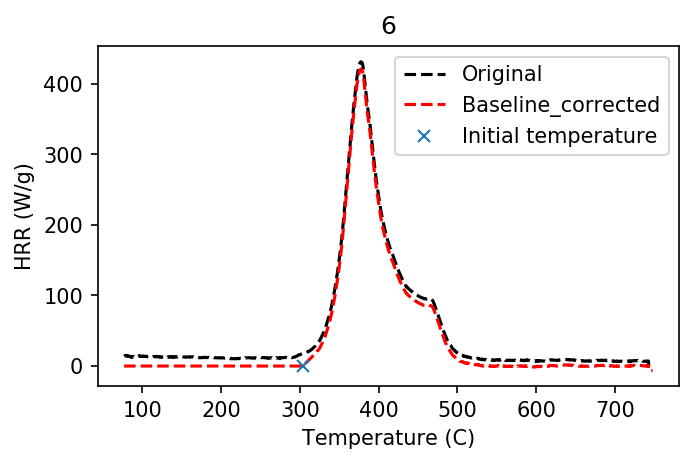

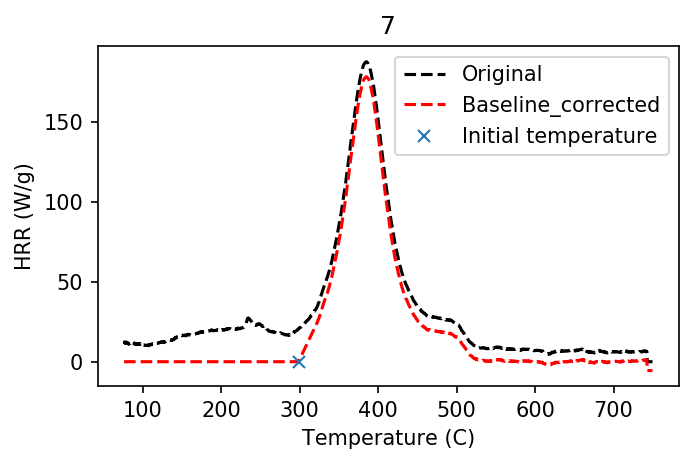

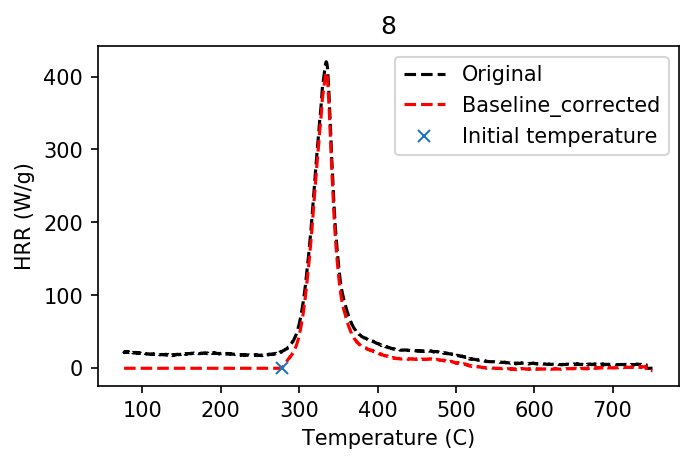

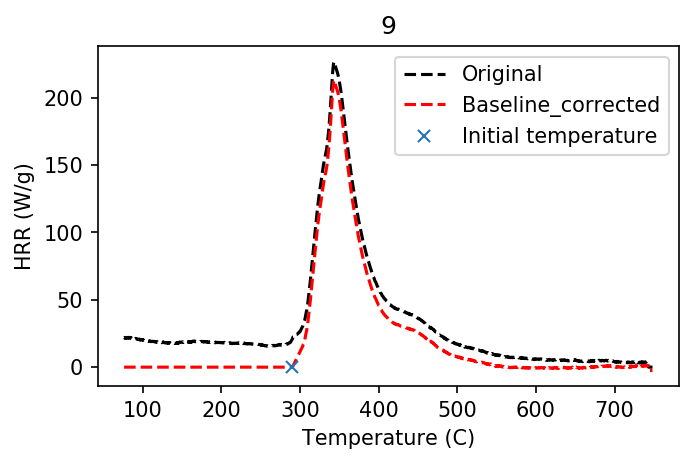

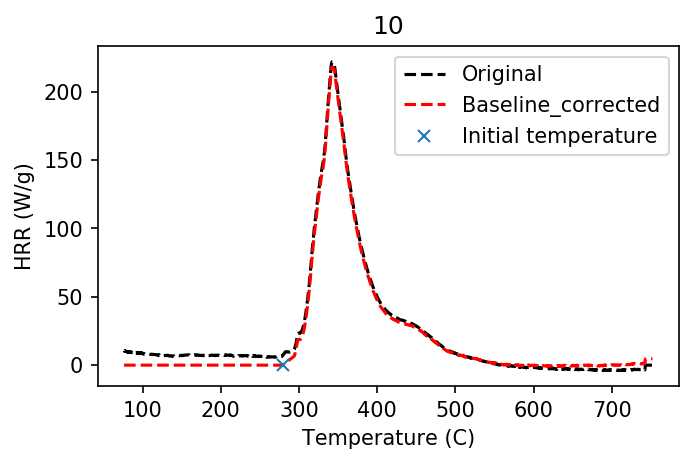

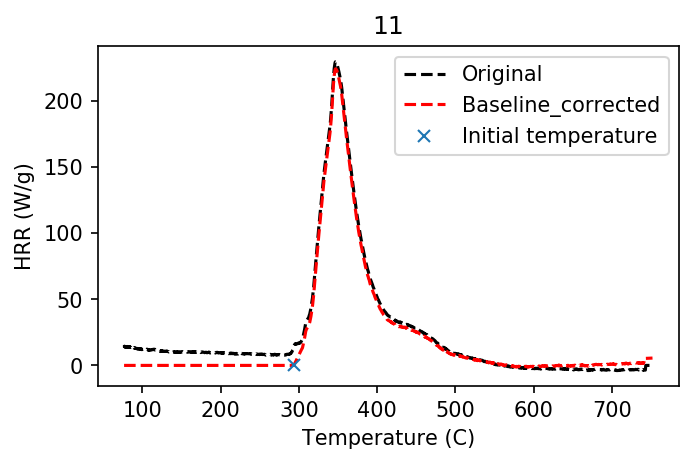

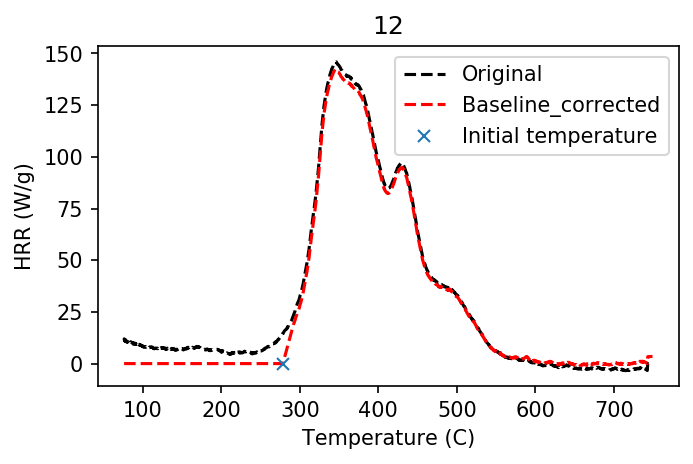

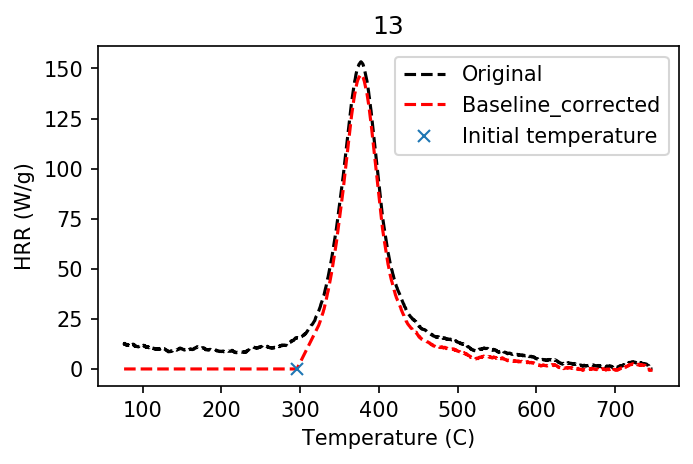

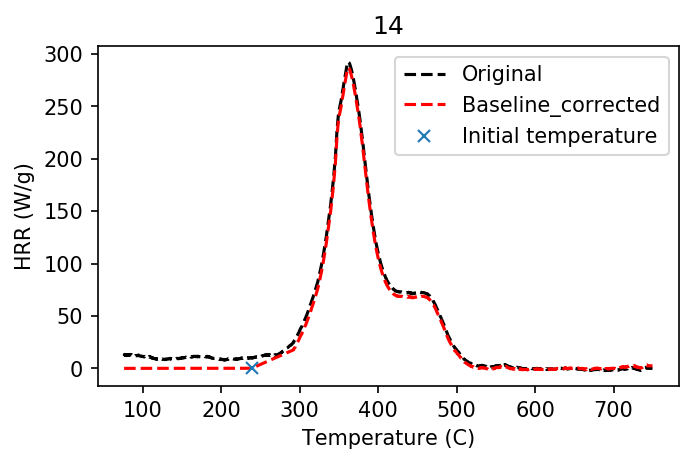

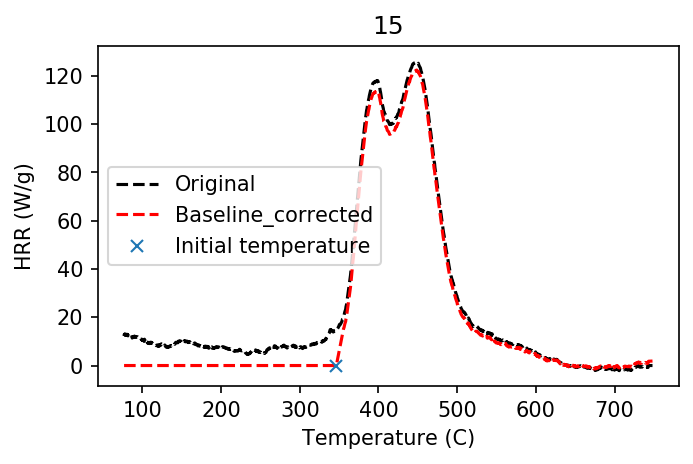

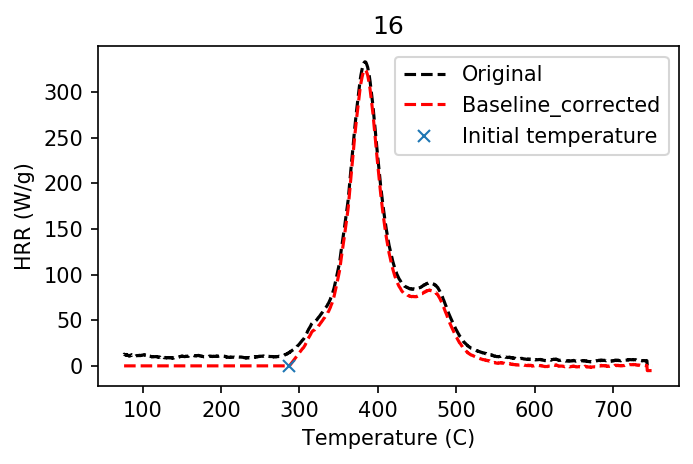

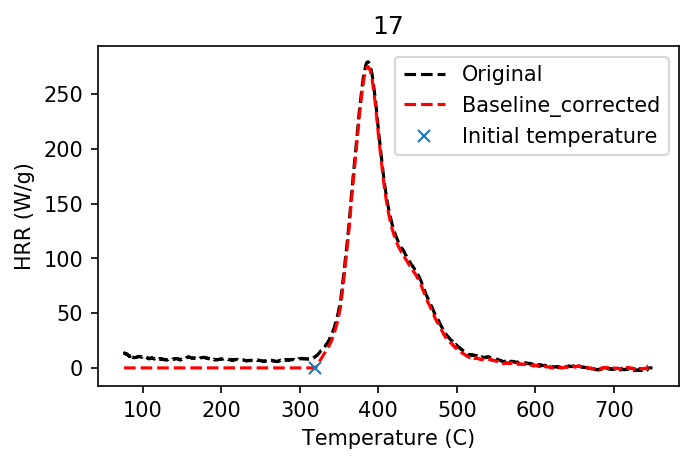

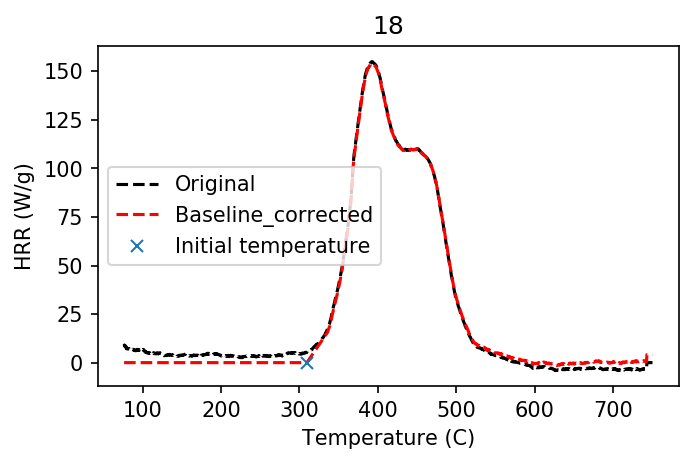

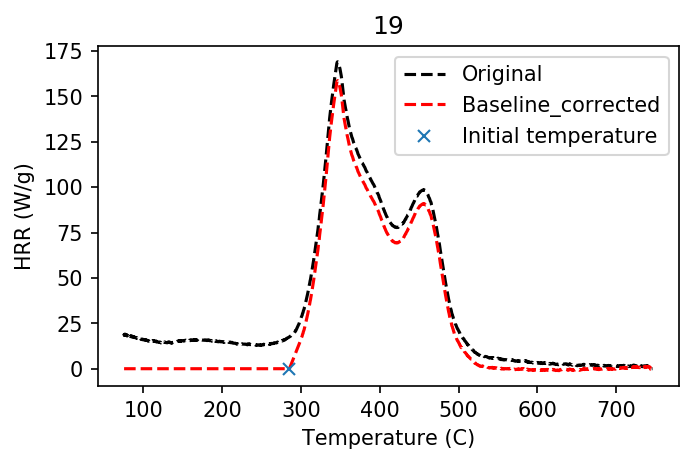

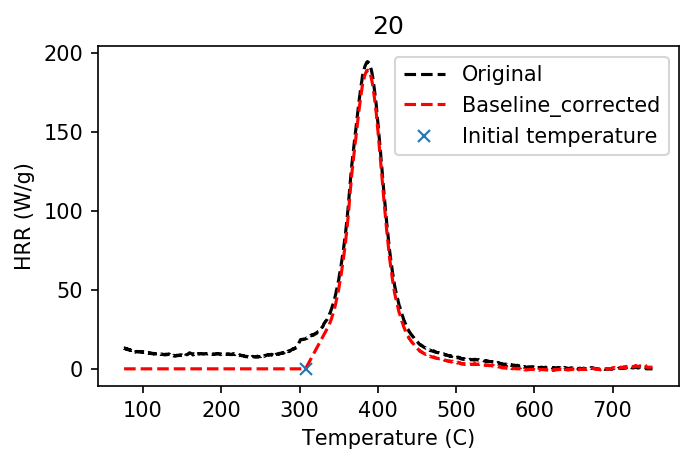

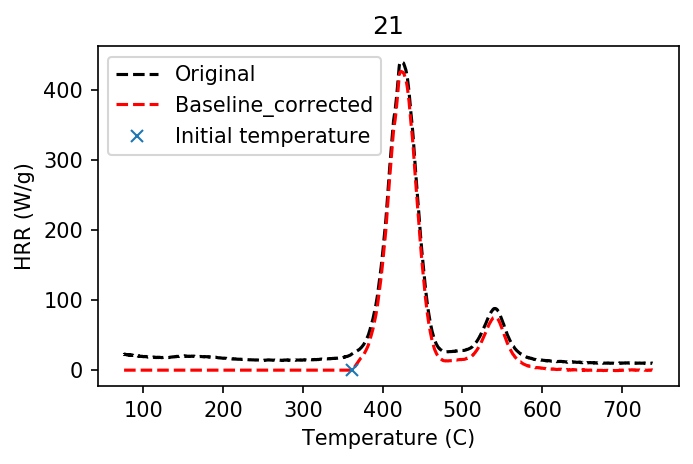

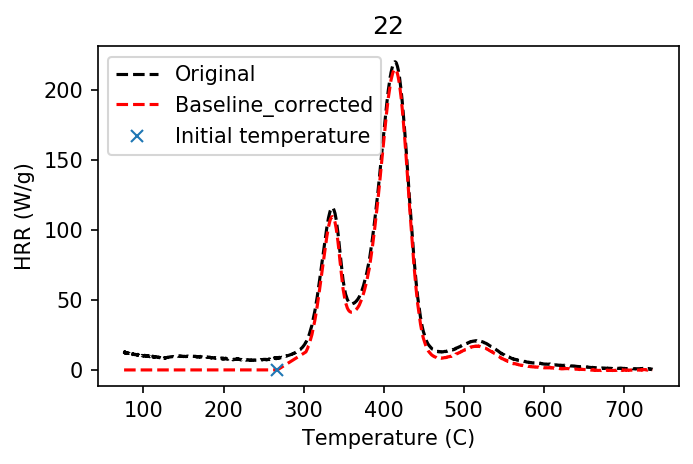

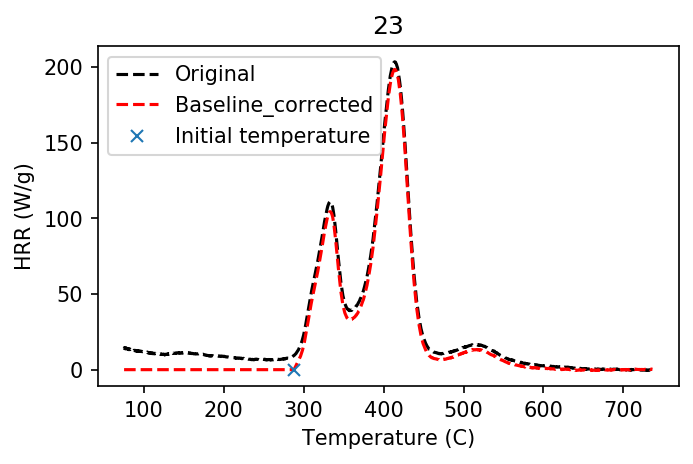

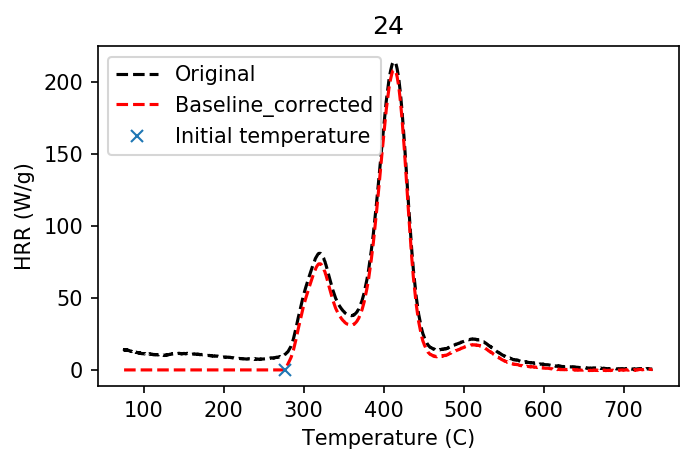

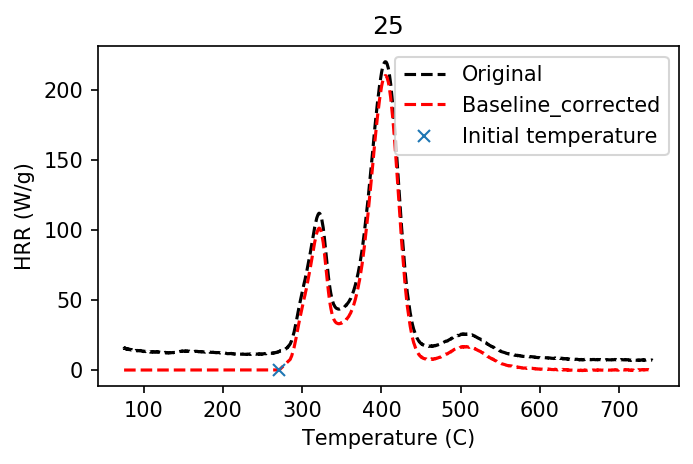

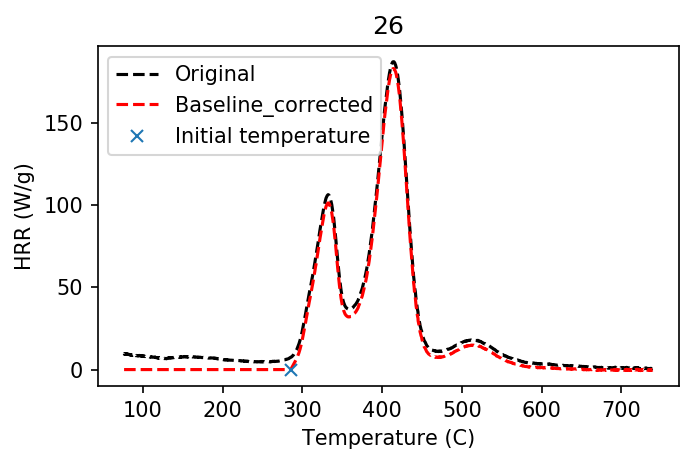

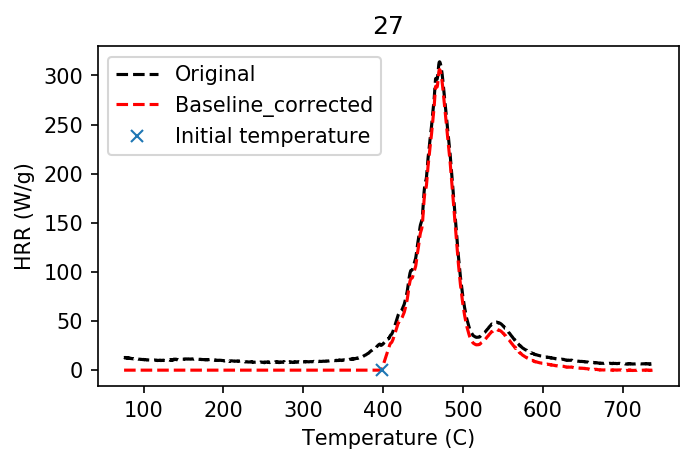

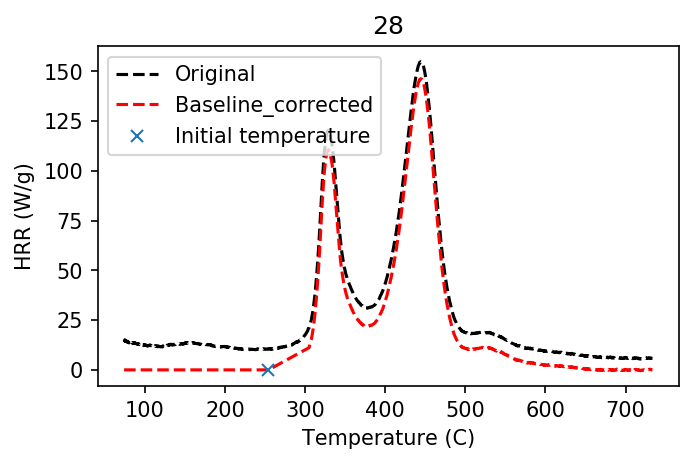

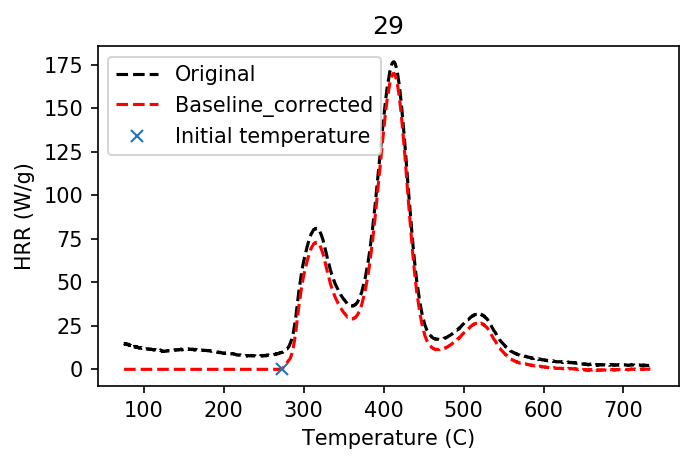

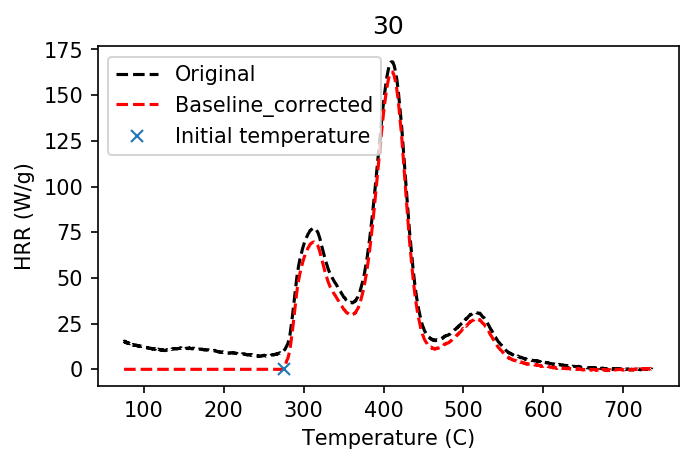

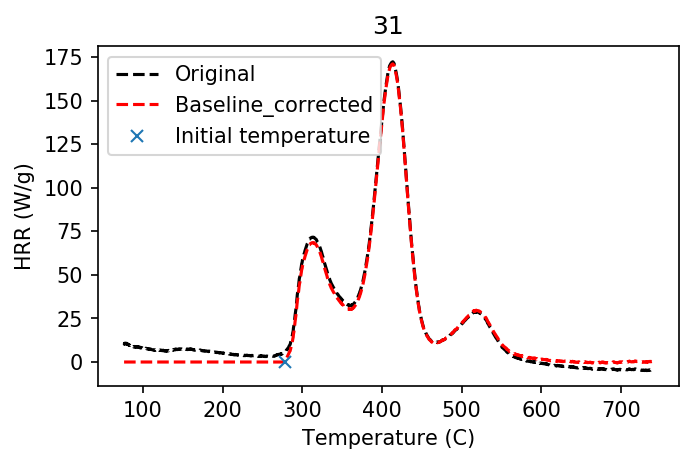

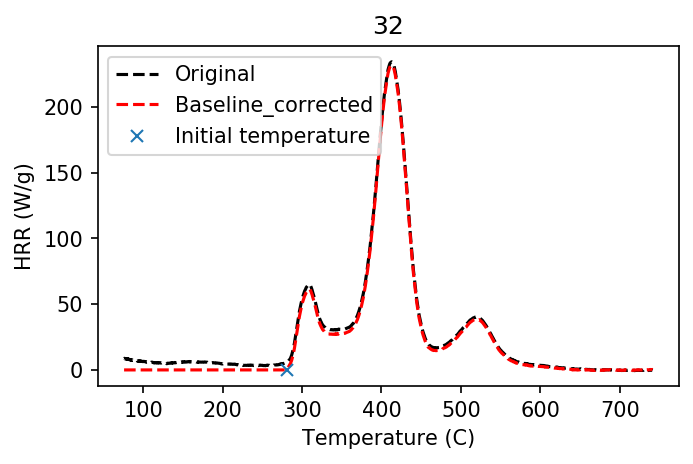

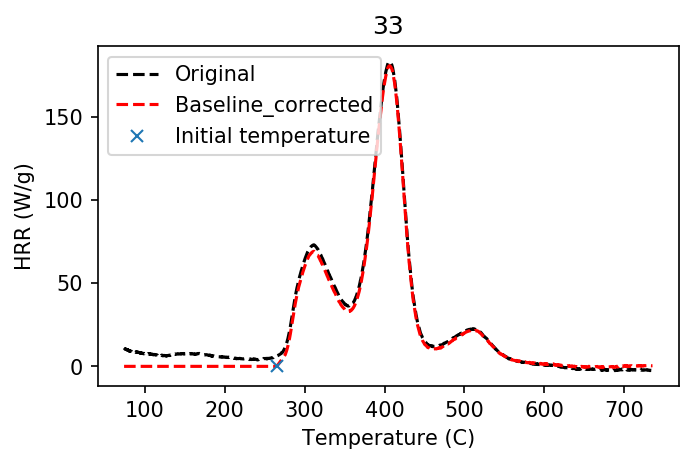

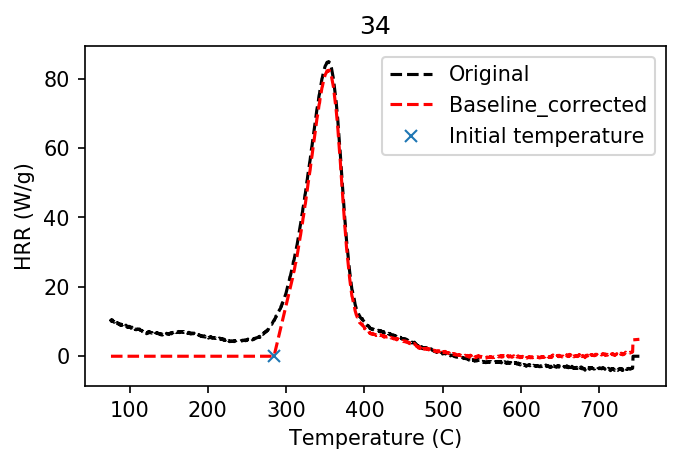

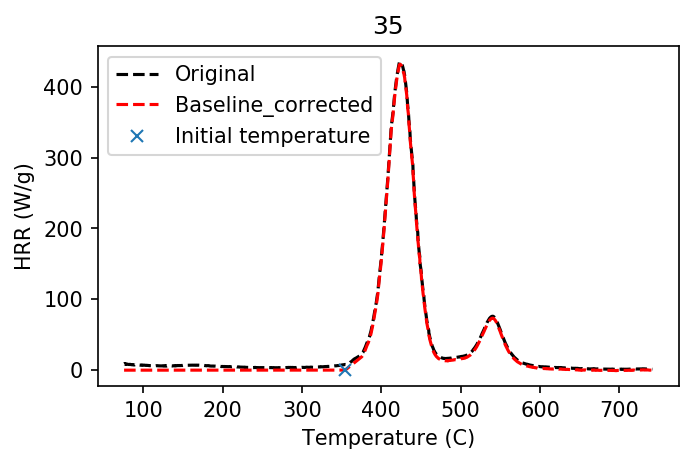

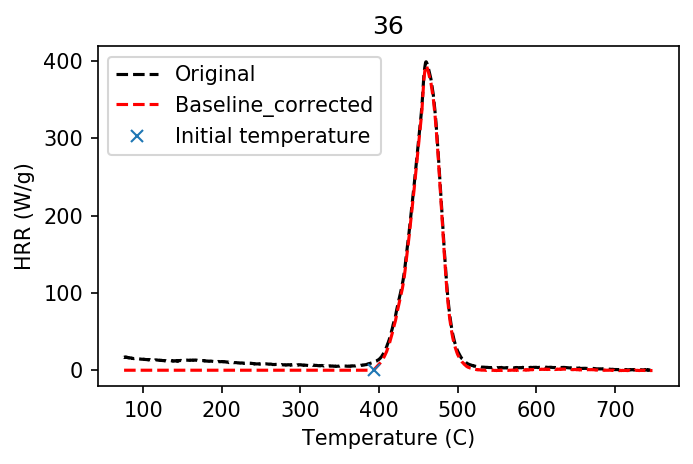

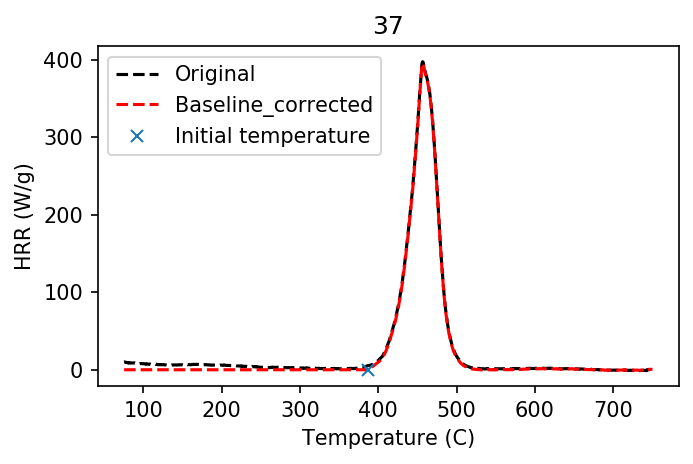

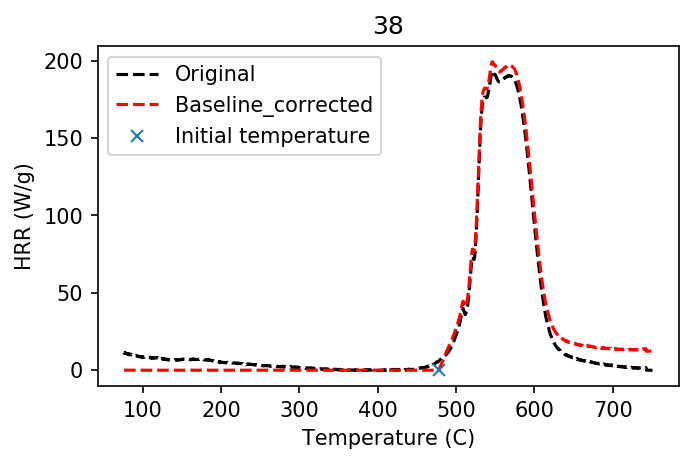

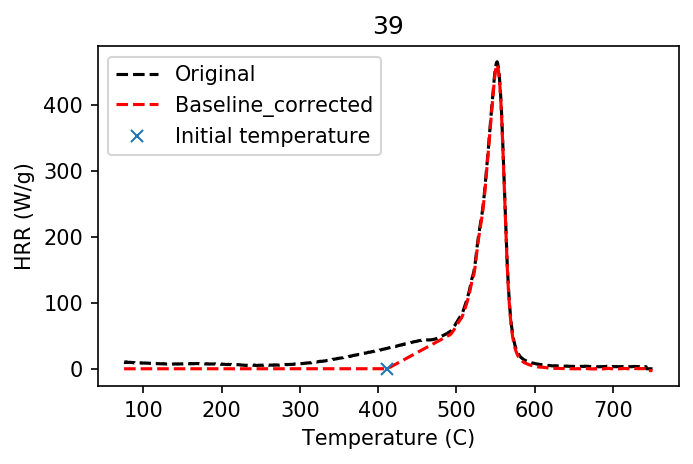

In [21]:
# imports
import warnings
warnings.filterwarnings("ignore") 

# test for baseline correction
# this is a cell used for testing and demonstration,
# the actual calculation will be performed at the end of this file

df = pd.read_csv('Data/Final_zs.csv')
df=np.array(df)
subdf=df[20:1420,0:120]
x_all = subdf[:,0::3]
y_all = subdf[:,1::3]
for i in range(40):
    x_b,y_b,x_init=baseline_correction(x_all[:,i], y_all[:,i])
    fig, ax = plt.subplots(figsize = (5, 3), dpi = 150)
    ax.plot(x_all[:,i], y_all[:,i],color='black', ls = '--')
    ax.plot(x_all[:,i], y_b[:,0],color='red', ls = '--')
    ax.plot(x_init,0,'x')
    ax.legend([ 'Original','Baseline_corrected','Initial temperature'])
    ax.set_xlabel('Temperature (C)')
    ax.set_ylabel('HRR (W/g)');
    ax.set_title(i)

### Total Heat Release Rate (THR)

> Total Heat Release Rate (THR) is the area under the curve 

In [22]:
# imports
import scipy
from scipy import integrate

# Calculates the area under the curve
#
# params: x, array of temperature values; y, array of HRR values
# returns: THR, the value for total heat release rate

def calculate_THR(Temp,HRR):
    return max(scipy.integrate.cumtrapz(Temp,HRR))


### Burning Temperature

> $T_{burning}$ = The temperature when 95% of the heat is released for the material

In [23]:
# Finds the temperature corresponding to the highest peak
#
# params: x, array of temperature values; y, array of HRR values
# returns: Tb, the burning temperature
def calculate_Tb(Temp,HRR):
    THR = calculate_THR(Temp, HRR)
    for i in range(len(Temp)):
      #print(np.trapz(HRR[:i]))
      if np.trapz(HRR[:i]) >= 0.95*THR:
        break
    # return Temp[np.argmax(HRR)]
    return Temp[i]

### Ignition Temperature

> $T_{ignition}$ = The temperature at peak HRR

In [24]:
# Finds the temperature corresponding to start of the highest peak
#
# params: x, array of temperature values; y, array of HRR values
# returns: Tign, the ignition temperature
def calculate_Tign(Temp,HRR):
    return Temp[np.argmax(HRR)]

### Heat Release Capacity (HRC)

> HRC = $\frac{Heat Released}{Heat of Pyrolysis}$ = $\frac{THR}{HR_{average}}$

In [25]:
# Calculates HRC using THR and heat of pyrolysis (Q/HR_average)
#
# params: THR, the total heat release; Tign, ignition temperature; Tinf, final temperature?
# returns: HRC, the heat release capacity
def calculate_HRC(THR,HR):
    HR_average = np.average(HR)
    HRC = THR/HR_average
    return HRC

### Fire Growth Capacity (FGC)

> FGC = $(\frac{THR}{T_{burning} - T_{ignition}})(\frac{T_{burning} - T_0}{T_{ignition} - T_0})$  
 ($T_0$ = 25$^{\circ}$C)

In [26]:
# Calculates the FGC using THR, ignition temperature, and burning temperature
#
# params: THR, the total heat release; Tign, ignition temperature; Tb, burning temperature
# returns: FGC, the fire growth capacity
def calculate_FGC(THR, Tb, Tign):
    FGC = (THR/(Tb - Tign))/((Tb - 25)/(Tign - 25))
    return FGC

## Final Results

In [27]:
# setup lists to store desired features
THRs = []
Tbs = []
Tigns = []
HRCs = []
FGCs = []

# Iterate and generate arrays for desired features
for i in range(0, data.shape[1], 3):
    # extract values for x and y and HR
    select = data.iloc[:,i:i+3]
    select = select.dropna()
    x = select.iloc[:,0].values
    y = select.iloc[:,1].values
    HR = select.iloc[:,2].values

    # perform data manipulation to get desired features
    x_b, y_b, _ = baseline_correction(x,y)
    y_b = y_b.reshape(-1)
    THR = calculate_THR(x_b,y_b)
    Tb = calculate_Tb(x_b,y_b)
    Tign = calculate_Tign(x_b,y_b)
    HRC = calculate_HRC(THR,HR)
    FGC = calculate_FGC(THR, Tb, Tign)
    THRs.append(THR)
    Tbs.append(Tb)
    Tigns.append(Tign)
    HRCs.append(HRC)
    FGCs.append(FGC)

# setup dataframe for feature matrix
feature_matrix = pd.DataFrame()
feature_matrix['Total Heat Release'] = THRs
feature_matrix['Burning Temperature'] = Tbs
feature_matrix['Ignition Temperature'] = Tigns
feature_matrix['Heat Release Capacity'] = HRCs
feature_matrix['Fire Growth Capacity'] = FGCs

# Add column for FR test result labels
feature_matrix['FR_labels'] = FR_labels

# print resulting feature matrix
feature_matrix

# for numpy array:
#feature_matrix.values

,Total Heat Release,Burning Temperature,Ignition Temperature,Heat Release Capacity,Fire Growth Capacity,FR_labels
0,70960.999086,754.030,350.805,74012.746080,78.647445,2
1,64241.445882,753.809,437.651,66883.953739,115.048327,2
2,36059.212221,753.661,366.975,37526.852334,43.764968,1
3,85051.381416,754.036,397.540,89034.124496,121.913176,0
4,138688.107907,753.505,388.929,145133.294434,190.035735,0
5,78075.498124,753.916,292.177,81734.739382,61.978319,1
6,148643.655141,753.761,377.380,155925.208883,190.961058,0
7,62349.933709,753.680,385.455,65159.272527,83.760050,1
8,127859.684347,753.959,334.539,133480.377120,129.448423,1
9,68811.200121,753.742,343.272,72093.137468,73.215384,1
